In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

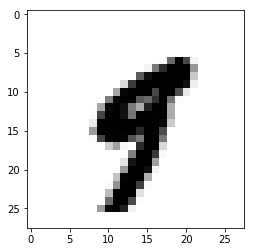

In [4]:
some_digit= X[36000]
some_digit_img = some_digit.reshape(28,28)
plt.imshow(some_digit_img, cmap=matplotlib.cm.binary, interpolation="nearest")

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [6]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


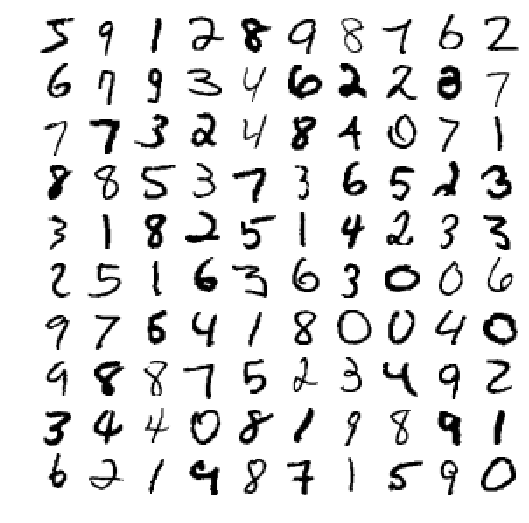

In [7]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
y[36000]

9

In [9]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

In [10]:
shuffle_index = np.random.permutation(60000)
X_train,  y_train = X_train[shuffle_index],  y_train[shuffle_index] 

In [11]:
y_train_9 = (y_train == 9)
y_test_9 = (y_test == 9)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train,y_train_9)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([False])

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_9):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_9[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_9[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.92785
0.9384
0.954


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.92785, 0.9384 , 0.954  ])

In [16]:
from sklearn.base import BaseEstimator

class Never9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_9_clf = Never9Classifier()
cross_val_score(never_9_clf, X_train, y_train_9, cv=3, scoring="accuracy")

array([0.9009 , 0.901  , 0.90065])

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_9, y_train_pred)

array([[52643,  1408],
       [ 2187,  3762]])

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_9, y_train_pred)

0.7276595744680852

In [21]:
recall_score(y_train_9, y_train_pred)

0.632375189107413

In [22]:
f1_score(y_train_9, y_train_pred)

0.676679557514165

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-87769.410348])

In [24]:
threshold = -202241
y_some_digit_pred = (y_scores> threshold)
y_some_digit_pred

array([ True])

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_9, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_9, y_scores)

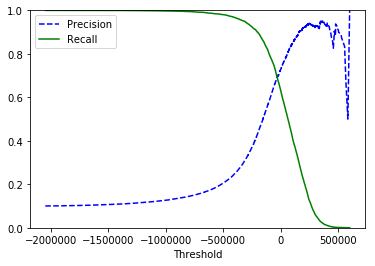

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


In [28]:
y_train_pred_90 = (y_scores>200000)

In [29]:
precision_score(y_train_9, y_train_pred_90)

0.9194346289752651

In [30]:
recall_score(y_train_9, y_train_pred_90)

0.21869221717935788

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_9, y_scores)

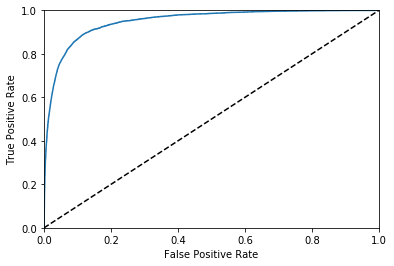

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=None)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_9, y_scores)

0.9495935677366948

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10 ,random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_9, cv=3, method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds__forest =roc_curve(y_train_9, y_scores_forest)

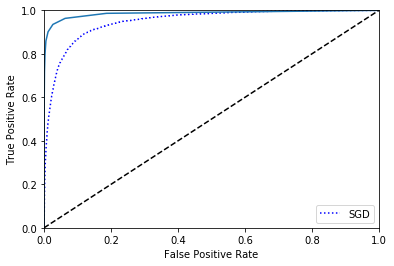

In [36]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [37]:
roc_auc_score(y_train_9, y_scores_forest)

0.9861939502489941

In [38]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=int8)

In [39]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-897286.06927846, -449708.48599591, -956560.35518418,
        -219115.75722686,  -22030.98229719, -106862.67004681,
        -695041.05342306, -227771.90487963, -174458.48706557,
         -87769.410348  ]])

In [40]:
np.argmax(some_digit_scores)

4

In [41]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [42]:
sgd_clf.classes_[9]

9

In [43]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([9], dtype=int8)

In [44]:
len(ovo_clf.estimators_)

45

In [45]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=int8)

In [46]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.9]])

In [47]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87947411, 0.86914346, 0.87048057])

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring="accuracy")

array([0.90706859, 0.9119956 , 0.91163675])

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5730,    4,   18,    8,   12,   51,   49,    9,   39,    3],
       [   1, 6472,   42,   25,    6,   45,    7,    9,  123,   12],
       [  57,   39, 5343,   93,   73,   27,   97,   57,  155,   17],
       [  53,   44,  137, 5344,    2,  227,   40,   52,  137,   95],
       [  22,   30,   35,    9, 5370,    7,   55,   34,   83,  197],
       [  74,   40,   32,  177,   74, 4622,  116,   27,  170,   89],
       [  32,   22,   49,    2,   33,   99, 5629,    6,   46,    0],
       [  23,   20,   76,   25,   53,   12,    5, 5789,   16,  246],
       [  52,  157,   70,  148,   15,  167,   56,   24, 5021,  141],
       [  46,   31,   24,   90,  154,   39,    2,  188,   81, 5294]])

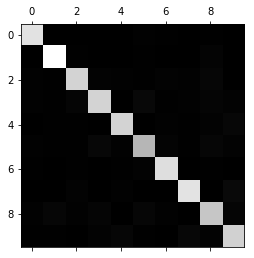

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
row_sums = conf_mx.sum(axis =1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

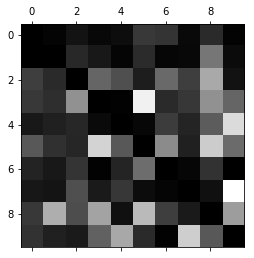

In [52]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

In [53]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a)& (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a)& (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b)& (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b)& (y_train_pred == cl_b)]

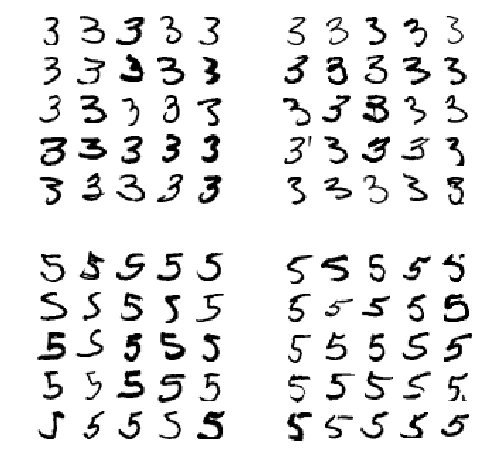

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

In [55]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train>=7)
y_train_odd = (y_train%2==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [56]:
knn_clf.predict([some_digit])

array([[ True,  True]])

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

f1_score(y_train, y_train_knn_pred, average="weighted")

In [63]:
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

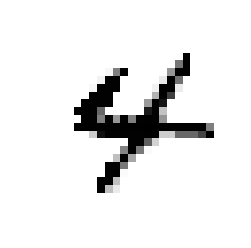

In [65]:
some_index = 5500
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)